In [59]:
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.types import BooleanType


# Create SparkSession 
spark = SparkSession.builder \
      .appName("SparkByExamples.com") \
      .getOrCreate() 

In [60]:
df = spark.read.option("header",True)\
        .option("inferSchema",True)\
        .option("delimiter",",")\
        .csv("gs://dataproc-sgtg-input/input/weblog.csv")
df.printSchema()

root
 |-- IP: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- Staus: string (nullable = true)



In [4]:
df.groupBy(F.col('Staus')).count().show()

+------------+-----+
|       Staus|count|
+------------+-----+
|         200|11330|
|       2018]|   28|
|     Aborted|    4|
|   Assertion|    4|
|         206|   52|
|         302| 3498|
|         404|  251|
|       2017]|    7|
|      dumped|    5|
|          No|  167|
|         304|  658|
|       found|    2|
|Segmentation|    1|
+------------+-----+



In [61]:
@F.udf(returnType=BooleanType()) 
def isInteger(s):
    try:
        int(s)
        return True
    except ValueError:
        return False
    
###
# Filter valid Staus
###
df = df.filter(isInteger(F.col('Staus')))
df.groupBy(F.col('Staus')).count().show()

+-----+-----+
|Staus|count|
+-----+-----+
|  200|11330|
|  206|   52|
|  302| 3498|
|  404|  251|
|  304|  658|
+-----+-----+



In [6]:
df.printSchema()

root
 |-- IP: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- Staus: string (nullable = true)



In [7]:
df.groupBy(F.col('URL')).count().withColumnRenamed("count", "frequency").filter(F.col("frequency")>10).show()

+--------------------+---------+
|                 URL|frequency|
+--------------------+---------+
|GET /compiler.php...|       98|
|GET /robots.txt H...|      224|
|GET /css/main.css...|      394|
|POST /pcompile.ph...|       77|
|POST /contestsubm...|       47|
|GET /js/jquery.mi...|       56|
|GET /home.php HTT...|     2640|
|GET /css/style.cs...|      395|
|GET /allsubmissio...|       11|
|POST /compile.php...|       95|
|      GET / HTTP/1.1|      861|
|GET /bootstrap-3....|      382|
|GET /contestsubmi...|       80|
|GET /details.php?...|       41|
|GET /contestsubmi...|       14|
|GET /standings.ph...|      153|
|GET /description....|       20|
|GET /login.php?va...|      128|
|GET /css/bootstra...|      404|
|GET /css/font-awe...|      399|
+--------------------+---------+
only showing top 20 rows



In [39]:
df.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
    .withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
    .groupBy(F.col('host'))\
    .count()\
    .withColumnRenamed('count','n')\
    .sort(F.col('n').desc())\
    .show()

+--------------------+----+
|                host|   n|
+--------------------+----+
|          /login.php|3426|
|           /home.php|2653|
|/js/vendor/modern...|1417|
|                   /| 862|
| /contestproblem.php| 556|
|  /css/normalize.css| 408|
|/css/bootstrap.mi...| 404|
|/css/font-awesome...| 399|
|      /css/style.css| 395|
|       /css/main.css| 394|
|/js/vendor/jquery...| 387|
|/bootstrap-3.3.7/...| 382|
|        /process.php| 317|
|        /archive.php| 309|
|        /details.php| 297|
|        /contest.php| 249|
|/fonts/fontawesom...| 246|
|/contestsubmissio...| 228|
|         /robots.txt| 224|
|       /img/ruet.png| 213|
+--------------------+----+
only showing top 20 rows



In [24]:
df.filter(F.col("Staus") != 200).groupBy(F.col("Staus"))\
    .count()\
    .sort(F.col("Staus").desc())\
    .show()

+-----+-----+
|Staus|count|
+-----+-----+
|  404|  251|
|  304|  658|
|  302| 3498|
|  206|   52|
+-----+-----+



In [40]:
df.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
    .withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
    .select(F.col('host'))\
    .distinct()\
    .show()

+--------------------+
|                host|
+--------------------+
|        /contest.php|
|      /css/style.css|
|/js/vendor/moment...|
|       /img/ruet.png|
|         /submit.php|
|       /pcompile.php|
|   /js/jquery.min.js|
|/fonts/glyphicons...|
|        /archive.php|
|/css/bootstrap.mi...|
|   /announcement.php|
|         /logout.php|
|/fonts/fontawesom...|
|/fonts/fontawesom...|
|           /edit.php|
|      /standings.php|
|     /setcontest.php|
|/css/bootstrap.mi...|
|/bootstrap-3.3.7/...|
|    /editcontest.php|
+--------------------+
only showing top 20 rows



In [38]:
df\
.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
.withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
.withColumn(
    'dt',
    F.to_timestamp(F.regexp_replace(F.col('Time'),'\[',''), 'dd/MMM/yyyy:HH:mm:ss')
)\
.withColumn(
    'day',
    F.date_format(F.col('dt'), 'yyyy-MM-dd')
)\
.groupBy('day').agg(F.countDistinct(F.col('host')))\
.show()

+----------+-----------+
|       day|count(host)|
+----------+-----------+
|2017-12-22|         11|
|2018-02-27|         24|
|2017-12-03|         35|
|2018-02-23|         34|
|2017-12-01|         37|
|2017-12-02|         32|
|2017-12-18|         36|
|2018-02-26|         18|
|2018-02-17|         16|
|2018-02-15|         14|
|2018-01-16|         29|
|2018-02-16|         15|
|2017-12-21|         24|
|2017-11-09|         22|
|2017-11-08|         16|
|2018-02-18|         20|
|2018-02-22|         34|
|2018-01-17|         13|
|2017-12-14|         31|
|2017-12-17|         22|
+----------+-----------+
only showing top 20 rows



In [29]:
df.filter(F.col('Staus') == 304).count()

658

In [32]:
df\
.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
.withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
.filter(F.col('Staus') == 304)\
.groupBy(F.col('host')).count()\
.sort(F.col('count').desc())\
.show(5)

+--------------------+-----+
|                host|count|
+--------------------+-----+
|/js/vendor/modern...|   71|
|/js/vendor/jquery...|   69|
|/css/bootstrap.mi...|   68|
|/css/font-awesome...|   68|
|       /css/main.css|   68|
+--------------------+-----+
only showing top 5 rows



In [33]:
df\
.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
.withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
.filter(F.col('Staus') == 302)\
.groupBy(F.col('host')).count()\
.sort(F.col('count').desc())\
.show(5)

+-------------------+-----+
|               host|count|
+-------------------+-----+
|          /home.php| 2167|
|                  /|  741|
|       /process.php|  317|
|        /action.php|   83|
|/contestproblem.php|   75|
+-------------------+-----+
only showing top 5 rows



<AxesSubplot:xlabel='day'>

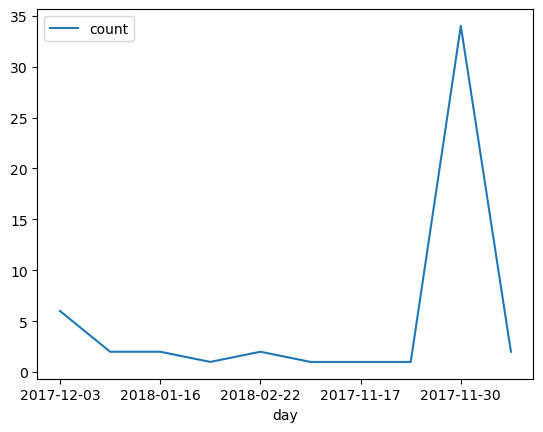

In [51]:
df\
.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
.withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
.withColumn(
    'dt',
    F.to_timestamp(F.regexp_replace(F.col('Time'),'\[',''), 'dd/MMM/yyyy:HH:mm:ss')
)\
.withColumn(
    'day',
    F.date_format(F.col('dt'), 'yyyy-MM-dd')
)\
.filter(F.col('Staus').isin(['206','205']))\
.groupBy(F.col('day')).count()\
.toPandas()\
.plot.line(x='day', y='count')

<AxesSubplot:>

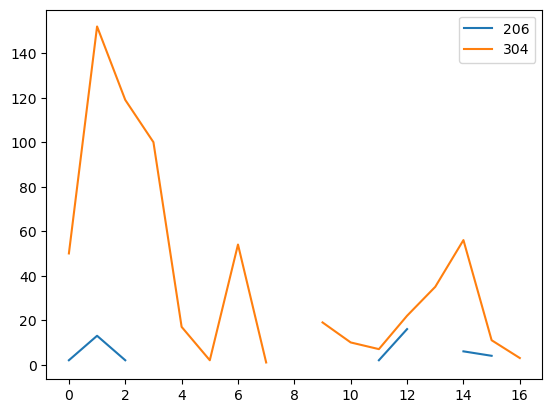

In [109]:
df\
.withColumn('host_prev', F.split(F.col('URL'), ' ').getItem(1))\
.withColumn('host', F.split(F.col('host_prev'), '\?').getItem(0))\
.withColumn(
    'dt',
    F.to_timestamp(F.regexp_replace(F.col('Time'),'\[',''), 'dd/MMM/yyyy:HH:mm:ss')
)\
.withColumn(
    'hour',
    F.date_format(F.col('dt'), 'HH')
)\
.filter(F.col('Staus').isin(['206','304']))\
.groupBy(F.col('hour')).pivot('Staus').count()\
.toPandas()\
.plot()